In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt

from scripts import analysis

In [2]:
repos = analysis.get_fake_star_repos_all()
print(
    f"{len(repos)} repos,",
    f"{len(repos[repos.n_stars_low_activity > 0])} with low activity,",
    f"{len(repos[repos.n_stars_clustered > 0])} with clusters,",
    f"{len(repos[(repos.n_stars_low_activity > 0) & (repos.n_stars_clustered > 0)])} with both",
)
repos.head()

15765 repos, 4095 with low activity, 12141 with clusters, 471 with both


,repo_id,repo_name,n_stars,n_stars_latest,n_stars_low_activity,p_stars_low_activity,n_stars_clustered,p_stars_clustered,p_stars_fake
0,NaN,zyzxxz/Bandicam-Lifetime-Crack-Free-Download,87.0,0.0,0.0,0.0,87.0,1.0,1.0
1,NaN,zz8nstokeronterry/dasdasfacxzcass,97.0,0.0,97.0,1.0,0.0,0.0,1.0
2,NaN,zyzxxz/IObit-Uninstaller-Latest-Version-Crack,77.0,0.0,0.0,0.0,77.0,1.0,1.0
3,NaN,zyzxxz/Autodesk-Maya-Crack,91.0,0.0,0.0,0.0,91.0,1.0,1.0
4,NaN,zyzxxz/ARK-2024,88.0,0.0,0.0,0.0,88.0,1.0,1.0


In [3]:
repos_dagster = pd.read_csv("data/dagster_test/fake_stars_complex_repos.csv")
stars_dagster = pd.read_csv("data/dagster_test/fake_stars_complex_users.csv")

repos_dagster = repos_dagster[(repos_dagster.n_fake_stars >= 50)]
repo_ids_dagster = set(repos_dagster.repo_id)

print(
    len(repo_ids_dagster),
    len(set(repos.repo_id) & repo_ids_dagster),
    repo_ids_dagster - set(repos.repo_id),
)
perfs = []
for repo_id in set(repos.repo_id) & repo_ids_dagster:
    repo_names = set(repos[repos.repo_id == repo_id].repo_name)
    fakes_copycatch, fakes_dagster = set(), set()
    for repo_name in repo_names:
        df = analysis.get_stars_from_repo(repo_name)
        if df is None:
            continue
        fakes_copycatch |= set(df[df.low_activity | df.clustered].actor)
        fakes_dagster |= set(
            stars_dagster[
                (stars_dagster.repo_name == repo_name)
                & (stars_dagster.fake_acct != "unknown")
            ].actor
        )
    perfs.append(
        {
            "repo_names": repo_names,
            "n_fakes_copycatch": len(fakes_copycatch),
            "n_fakes_dagster": len(fakes_dagster),
            "n_overlap": len(fakes_copycatch & fakes_dagster),
        }
    )
perfs = pd.DataFrame(perfs)
print("Precision:", perfs.n_overlap.sum() / perfs.n_fakes_copycatch.sum())
print("Recall:", perfs.n_overlap.sum() / perfs.n_fakes_dagster.sum())
perfs

44 41 {'R_kgDOHxZ6lw', 'MDEwOlJlcG9zaXRvcnk4OTkxMzY1NQ==', 'MDEwOlJlcG9zaXRvcnkyMTM2NDkyMTM='}
Precision: 0.7433702689243028
Recall: 0.21571018262613126


,repo_names,n_fakes_copycatch,n_fakes_dagster,n_overlap
0,{airbnb/javascript},962,5920,468
1,{fluid-player/fluid-player},51,51,51
2,{microsoft/vscode},2651,6214,1098
3,{pedroslopez/whatsapp-web.js},161,320,161
4,{mrdoob/three.js},1179,2685,494
5,{puppeteer/puppeteer},102,714,102
6,{nocodb/nocodb},154,551,154
7,{twbs/bootstrap},856,4479,722
8,{facebook/react},2784,3024,26
9,{storybookjs/storybook},232,2765,232


In [4]:
stars = analysis.get_stars_by_month_all()
stars.head()

,repo,month,n_stars,n_stars_low_activity,n_stars_clustered,n_stars_other
0,002sj/Crypto-Trading-Bots-for-FREE-Binance-ByB...,2024-02,672.0,0.0,672.0,0.0
1,00Gaurav-Chauhan00/4k-Video-Downloader-Crack,2024-04,495.0,0.0,495.0,0.0
2,00x1337/Adobe-Main,2024-04,240.0,0.0,240.0,0.0
3,01072006/der8gyXjjYMQ6KFVAg,2024-04,65.0,59.0,0.0,6.0
4,01kaim/t8gj,2024-03,88.0,0.0,81.0,7.0


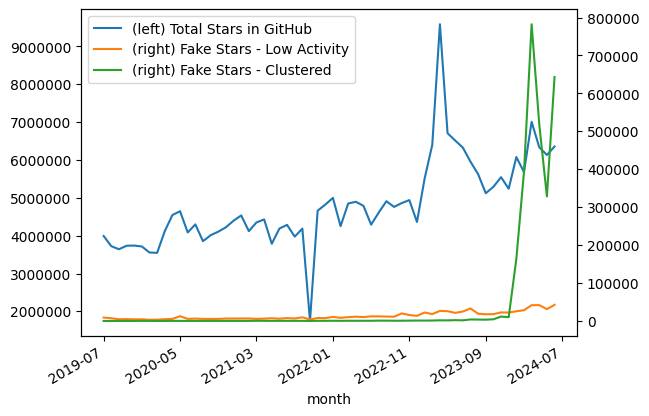

In [5]:
fig, ax = plt.subplots()
pd.read_csv("data/stars_by_month.csv").plot(ax=ax, secondary_y=False, logy=False)
ax2 = (
    stars[stars.month != "2024-07"]
    .groupby("month")
    .agg(
        n_stars_low_activity=("n_stars_low_activity", "sum"),
        n_stars_clustered=("n_stars_clustered", "sum"),
    )
    .plot(ax=ax, secondary_y=True, logy=False)
)
# Ugly formatting code
ax2.ticklabel_format(style="plain", axis="y")
ax.ticklabel_format(style="plain", axis="y")
labels = ax.get_xticklabels()
labels[7].set_text("2024-07")
ax.set_xticklabels(labels)
ax.legend(
    labels=[
        "(left) Total Stars in GitHub",
        "(right) Fake Stars - Low Activity",
        "(right) Fake Stars - Clustered",
    ],
    handles=[ax.lines[0], ax2.lines[0], ax2.lines[1]],
)
fig.autofmt_xdate()

In [6]:
stars["seems_like_compaign"] = (stars["n_stars_low_activity"] >= 50) & (
    stars["n_stars_low_activity"] / stars["n_stars"] >= 0.5
) | (
    (stars["n_stars_clustered"] >= 50)
    & (stars["n_stars_clustered"] / stars["n_stars"] >= 0.5)
)

repos_all = set(stars.repo)
repos_with_compaign = set(stars[stars.seems_like_compaign].repo)
repos_alive = set(repos[repos.repo_id.notna()].repo_name)

print(f"{len(repos_with_compaign)} of {len(repos_all)} repos with campaign")
print(f"{len(repos_alive)} of {len(repos_all)} repos alive")
print(f"{len(repos_with_compaign & repos_alive)} repos with campaign and alive")

10174 of 15765 repos with campaign
5649 of 15765 repos alive
1161 repos with campaign and alive


Text(0.5, 0, '# of Active Months')

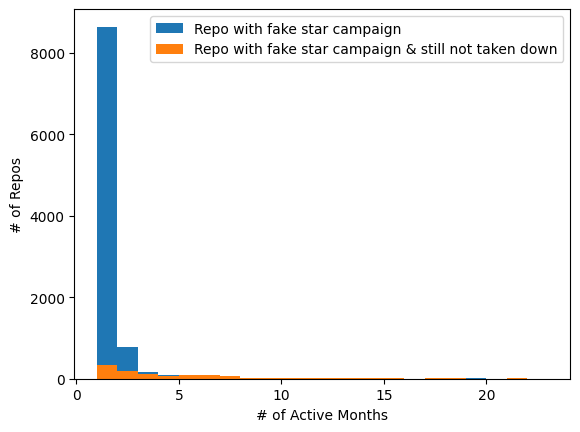

In [7]:
repo_to_months = (
    stars.groupby("repo")
    .agg(
        n_months=("month", "count"),
    )
    .reset_index()
)

fig, ax = plt.subplots()
repo_to_months[repo_to_months.repo.isin(repos_with_compaign)].plot(
    kind="hist",
    bins=range(1, 24),
    ax=ax,
)
repo_to_months[repo_to_months.repo.isin(repos_with_compaign & repos_alive)].plot(
    kind="hist",
    bins=range(1, 24),
    ax=ax,
)
ax.legend(
    [
        "Repo with fake star campaign",
        "Repo with fake star campaign & still not taken down",
    ]
)
ax.set_ylabel("# of Repos")
ax.set_xlabel("# of Active Months")

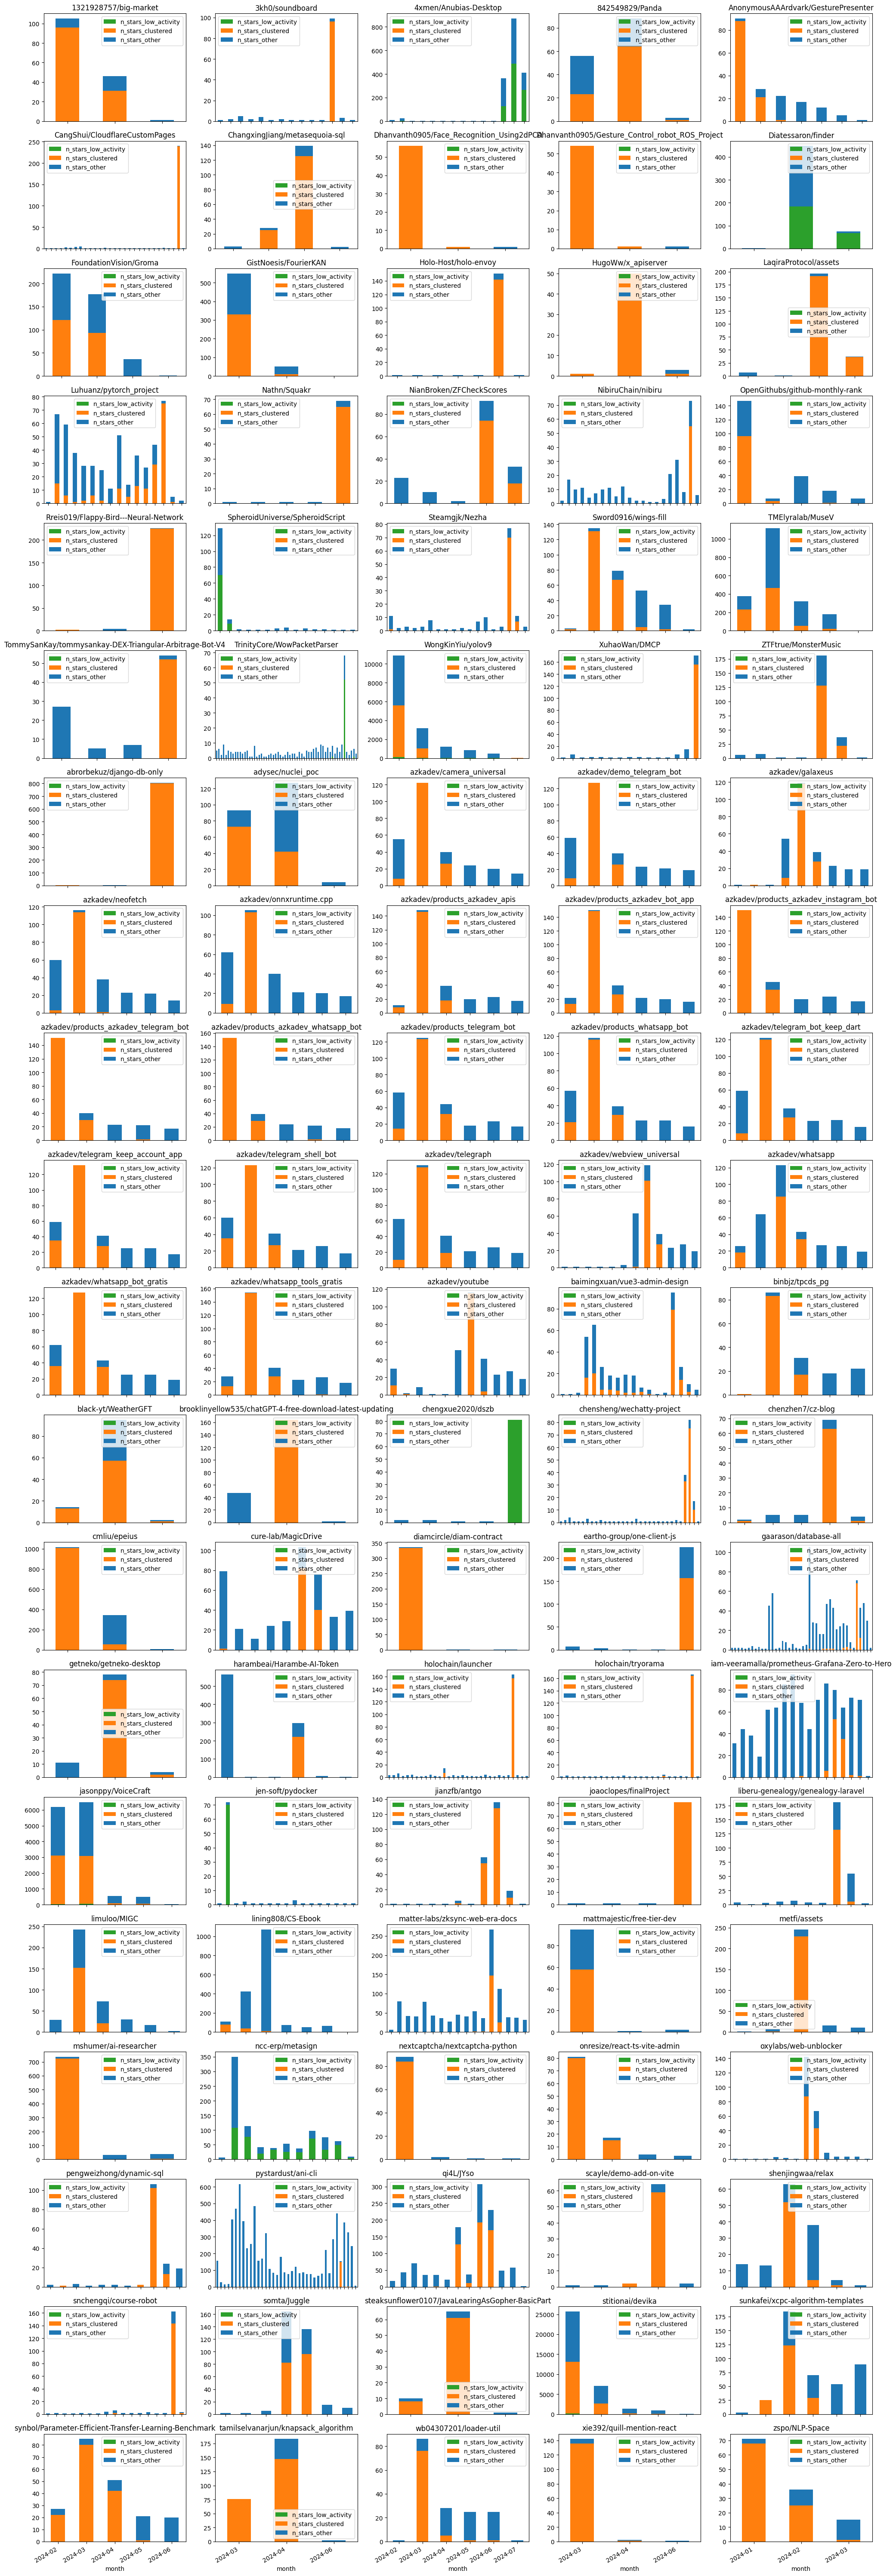

In [9]:
repo_samples = random.sample(
    sorted(
        (repos_alive & repos_with_compaign)
        & set(repo_to_months[repo_to_months.n_months >= 3].repo)
    ),
    100,
)
# repo_samples = list(successful_repos.head(100).repo_name)

fig, axes = plt.subplots(20, 5, figsize=(20, 60))
for i, (repo, df) in enumerate(stars[stars.repo.isin(repo_samples)].groupby("repo")):
    df[["month", "n_stars_low_activity", "n_stars_clustered", "n_stars_other"]].plot(
        kind="bar",
        x="month",
        stacked=True,
        ax=axes[i // 5, i % 5],
        title=repo,
        color=["C2", "C1", "C0"],
    )
fig.autofmt_xdate()
fig.tight_layout()